_All data was collected on 06 Feb 2024._

In [1]:
import logging
import os
import shutil
import sqlite3
import time
import re
import requests
from collections import defaultdict

import networkx as nx
import praw
import pandas as pd
from selenium import webdriver #also need a standalone chromedriver executable
from tqdm.notebook import tqdm, trange
from dotenv import load_dotenv
from matplotlib_venn import venn2

In [2]:
logging.basicConfig(level=logging.INFO)
load_dotenv(); #loading environmental variables from .env

In [3]:
def notify(title, message):
    #Send a Telegram message using noti
    #https://github.com/variadico/noti
    if shutil.which("noti"):
        os.system("noti -g -t '%s' -m '%s'" % (title, message))

# Getting list of subreddits

## Getting top 25'000 subreddits from www.reddit.com/best/communities/1/

In [ ]:
base_url = "https://www.reddit.com/best/communities/%i/"
regex = re.compile(r'data-prefixed-name="r/([^\"]*)"') #regex found by inspecting the source code
top_subs = []

for i in tqdm(range(1, 100)):
    res = requests.get(base_url % i)
    subs = regex.findall(res.text)
    top_subs += subs
    time.sleep(0.1)

In [47]:
with open('top-subreddits.txt', 'w') as f:
    f.write('\n'.join(top_subs) + '\n')

One of the subs, `r/rachelweaversnark` later on turned out to be private. I removed it from the list, which now contains 24'999 subreddits.

##  Getting most popular subreddits from www.reddit.com/subreddits/

Note than some of Reddit's most popular communities are [missing](https://www.reddit.com/r/ModSupport/comments/xu57y6/our_subreddit_is_not_showing_in_the_best_reddit/) from www.reddit.com/top/communities/1/. That's probably because Reddit doesn't want to suggest NSFW or controversial communities to new users or advertisers. Some examples of missing subs:
* `r/iamatotalpieceofshit`
* `r/therewasanattempt`
* `r/illusions`
* `r/Palestine`
* `r/PublicFreakout`
* `r/CombatFootage`
* `r/FUCKYOUINPARTICULAR`
* `r/IsItBullshit`
* `r/IdiotsFightingThings`
* `r/JordanPeterson`
* `r/MensRights`
* `r/OneSecondBeforeDisast`
* `r/TIHI`
* `r/ThatsInsane`
* `r/TrueUnpopularOpinion`
* `r/Wellthatsucks`
* `r/Whatcouldgowrong`
* `r/cringe`
* `r/sex`
* `r/stupidquestions`

To overcome the issue, I also scraped all the most popular communities listed at www.reddit.com/subreddits/. There was a total of 4336 of them.

In [ ]:
#Old Reddit blocks non-browser requests, so I've got to use Selenium

with open("popular-subreddits.txt", "w") as out:
    url = "https://www.reddit.com/subreddits"
    regex_subs = re.compile(r'class="titlerow"><a href="https://www.reddit.com/r/([^"]+)/"')
    regex_next = re.compile(r'<span class="next-button">\s*<a href="([^"]*)')
    driver = webdriver.Chrome()

    while True:
        driver.get(url)
        source = driver.page_source
        next_subs = regex_subs.findall(source)
        out.write('\n'.join(next_subs) + '\n')
        matches = regex_next.findall(source)
        if not matches:
            break #reached end of list
        [url] = matches
        out.flush()
        time.sleep(5)

## Pooling two lists together 

In [6]:
with open("popular-subreddits.txt", "r") as f:
    popular_subs = [s.strip() for s in f.readlines()]
    
with open("top-subreddits.txt", "r") as f:
    top_subs = [s.strip() for s in f.readlines()]

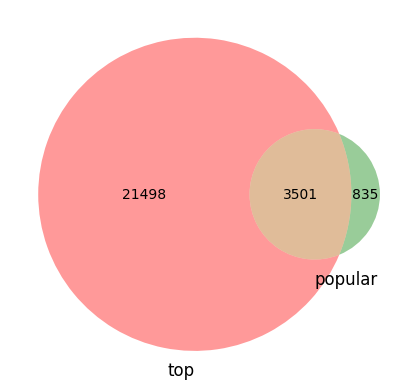

In [14]:
venn2([set(top_subs), set(popular_subs)], set_labels=('top', 'popular'));

In [15]:
#first writing popular subs, then top subs
with open("all-subreddits.txt", 'w') as f:
    for s in popular_subs:
        f.write(s + '\n')
    popular_set = set(popular_subs)
    for s in top_subs:
        if s not in popular_set:
            f.write(s + '\n')

In [16]:
!wc -l all-subreddits.txt

   25834 all-subreddits.txt


I will be inspecting 25834 subs in total.

# Inspecting subreddits

To increase speed, I will be using two different Reddit accounts. I have authorized a `script` application for each of them on www.reddit.com/prefs/apps.

I will be using the schema
![](schema.png)

In [26]:
class DBFactory:

    db = None

    def __call__(self):
        DBFactory.db = DBFactory.db or sqlite3.connect('db.sqlite3')
        self.create_tables()
        self.init_tables()
        return self.db

    
    def create_tables(self):
        cursor = self.db.cursor()
        cursor.execute('''
            CREATE TABLE IF NOT EXISTS subs(
                name TEXT PRIMARY KEY,
                nsubscr INTEGER,
                processed BOOLEAN DEFAULT 0
            )
        ''')
        cursor.execute('''
            CREATE TABLE IF NOT EXISTS mods(
                mod TEXT,
                sub TEXT,
                PRIMARY KEY (mod, sub)
            )
        ''')
        cursor.execute('''
            CREATE TABLE IF NOT EXISTS bots(
                name TEXT PRIMARY KEY
            )
        ''')
        self.db.commit()
        cursor.close()

    def init_tables(self):
        cursor = self.db.cursor()
        known_bots = {
            'mod-mentions',
            'hive-protect',
            'comment-nuke',
            'purge-user',
            'spam-nuke',
            'modmail-userinfo',
            'onedayflair',
            'AutoModerator'
        }
        for bot_name in known_bots:
            cursor.execute("INSERT OR IGNORE INTO bots(name) VALUES(?)", (bot_name,))
        self.db.commit()
        cursor.close()
        

In [27]:
class SubInspector:
    
    def __init__(self, reddit):
        self.reddit = reddit
        self.db = DBFactory()()
        self.cursor = self.db.cursor()

    
    def inspect(self, *, sub_name=None):        
        self.cursor.execute("SELECT name FROM subs WHERE name=? AND processed=1", (sub_name,))
        if self.cursor.fetchone():
            return
            
        sub = self.reddit.subreddit(sub_name)
        self.cursor.execute("INSERT OR IGNORE INTO subs(name, nsubscr) VALUES(?,?)", (sub.display_name, sub.subscribers))
        for mod in sub.moderator():
            if self.is_bot(mod):
                continue
            self.cursor.execute("INSERT OR IGNORE INTO mods(mod, sub) VALUES(?,?)", (mod.name, sub.display_name))

        self.cursor.execute("UPDATE subs SET processed = 1 WHERE name = ?", (sub.display_name,))
        self.db.commit()
        time.sleep(0.5)
        logging.info(f'Inspected sub {sub.display_name}')


    def is_bot(self, mod):
        #identifying bots by name ONLY
        mod_name = mod.name
        self.cursor.execute("SELECT name FROM bots WHERE name=?", (mod.name,))
        if self.cursor.fetchone():
            return True
        elif mod_name.lower().startswith('bot') or mod_name.lower().endswith('bot'):
            self.cursor.execute("INSERT INTO bots(name) VALUES(?)", (mod.name,)) 
        else:
            return False
        self.db.commit()
        return True


    def set_reddit(self, reddit):
        self.reddit = reddit

    
    def __del__(self):
        self.cursor.close()
            

In [74]:
reddit1 = praw.Reddit(
    client_id=os.getenv("CLIENT_ID_1"),
    client_secret=os.getenv("CLIENT_SECRET_1"),
    user_agent=os.getenv("USER_AGENT_1"),
    username=os.getenv("USER_NAME_1"),
    password=os.getenv("USER_PASS_1")
)

reddit2 = praw.Reddit(
    client_id=os.getenv("CLIENT_ID_2"),
    client_secret=os.getenv("CLIENT_SECRET_2"),
    user_agent=os.getenv("USER_AGENT_2"),
    username=os.getenv("USER_NAME_2"),
    password=os.getenv("USER_PASS_2")
)

In [ ]:
with open('all-subreddits.txt', 'r') as f:
    all_subs = [s.strip() for s in f.readlines()]

inspector = SubInspector(reddit1)

for i, sub_name in enumerate(tqdm(all_subs)):
    #magic to overcome Reddit's ratelimits
    if i and i % 25 == 0:
        inspector.set_reddit(reddit2 if inspector.reddit is reddit1 else reddit1)
    if i and i % 50 == 0:
        time.sleep(10)
    if i and i % 500 == 0:
        time.sleep(10)
    if i and i % 1000 == 0:
        time.sleep(10)
    
    inspector.inspect(sub_name=sub_name)

notify("reddit-mod-db", f"Done processing top {len(all_subs)} subs!") 

# Writing output 

## Writing CSV 

In [29]:
db = DBFactory()()
cursor = db.cursor()

In [44]:
with open('../subreddits.csv', 'w') as f:
    f.write('name,n_members\n')
    cursor.execute("""
        SELECT name, nsubscr FROM subs ORDER BY nsubscr DESC;
    """)
    for name, n_members in tqdm(cursor.fetchall()):
        f.write(f'{name},{n_members}\n')

  0%|          | 0/25834 [00:00<?, ?it/s]

In [47]:
with open('../moderators.csv', 'w') as f:
    f.write(',moderator,subreddit\n')
    cursor.execute("""
        SELECT mods.mod, mods.sub FROM mods LEFT JOIN subs ON mods.sub = subs.name ORDER BY subs.nsubscr DESC;
    """)
    for i, (moderator, subreddit) in enumerate(tqdm(cursor.fetchall()), 1):
        f.write(f'{i},{moderator},{subreddit}\n')

  0%|          | 0/125812 [00:00<?, ?it/s]

In [69]:
with open('../bots.csv', 'w') as f:
    f.write('name\n')
    cursor.execute("""
        SELECT name FROM bots;
    """)
    for (name, ) in cursor.fetchall():
        f.write(name + '\n')

## Writing GEXF 

In [5]:
df_subs = pd.read_csv('../subreddits.csv')
df_mods = pd.read_csv('../moderators.csv', index_col=0)

In [6]:
df_mods.head()

,moderator,subreddit
1,spez,announcements
2,sodypop,announcements
3,Sporkicide,announcements
4,redtaboo,announcements
5,Chtorrr,announcements


In [7]:
df_subs.head()

,name,n_members
0,announcements,280481257
1,funny,56515611
2,AskReddit,44954249
3,gaming,39436141
4,aww,35362104


### Bipartite Graph

Writing as a bipartite graph, where both mods and subs are nodes.

In [15]:
g = nx.Graph()
g.add_nodes_from(df_mods['moderator'].unique(), bipartite=0)
g.add_nodes_from(df_mods['subreddit'].unique(), bipartite=1)
g.add_edges_from([tuple(row) for row in df_mods[['moderator', 'subreddit']].values])
nx.write_gexf(g, '../graph.gexf')